# DeepDream Guided Feature Transfer

This notebook demonstrates how to use DeepDream for guided dreaming - transferring features from a reference image to a source image. Guided dreaming allows you to blend visual characteristics from one image into another while maintaining the overall structure of the source image.

---

## 1. Setup and Imports

First, we'll import the necessary libraries and components from our DeepDream implementation.

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.models as models

# Import our DeepDream implementation
from deepdreaming import img
from deepdreaming.config import DreamConfig
from deepdreaming.deepdream import DeepDream

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)


# Helper functions for visualization
def show_image(img_array, title=None, figsize=(10, 10)):
    """Display a single image with optional title"""
    plt.figure(figsize=figsize)
    plt.imshow(img_array)
    plt.axis("off")
    if title:
        plt.title(title)
    plt.tight_layout()
    plt.show()


def show_images_row(images, titles=None, figsize=(15, 5)):
    """Display multiple images in a row"""
    n = len(images)
    plt.figure(figsize=figsize)
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        if titles and i < len(titles):
            plt.title(titles[i])
        plt.axis("off")
    plt.tight_layout()
    plt.show()

## 2. Load Sample Images

Let's load a set of sample images that we'll use for our guided dreaming experiments.

In [14]:
# Define paths to input images
input_dir = "input/deepdream-sample-images"
input_images = ["yoda.jpeg", "bombordiro_crocodilo.jpeg", "tree.png", "space.jpeg"]
image_files = sorted([os.path.join(input_dir, input_image) for input_image in input_images])

# Load images
images = []
for img_path in image_files:
    img_name = os.path.basename(img_path).split(".")[0]
    img_data = img.io.read_image(img_path, (224, 224, 3))
    images.append((img_name, img_data))

# Display loaded images
plt.figure(figsize=(15, 3.5))
for i, (name, img_data) in enumerate(images):
    plt.subplot(1, 4, i + 1)
    plt.imshow(img_data)
    plt.title(name)
    plt.axis("off")
plt.tight_layout()
plt.show()

print(f"Loaded {len(images)} images for guided dreaming")

Loaded 4 images for guided dreaming


## 3. Configure and Initialize DeepDream Model

Now we'll create a DeepDream configuration optimized for faster results and set up our model.

In [15]:
# Load pre-trained model (VGG16)
model = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
model.eval()

# Target layers for feature extraction
target_layers = ["features.13", "features.22", "features.25", "features.27", "features.29"]

# Create a fast configuration for guided dreaming
config = DreamConfig(gradient_norm=True, pyramid_layers=4, num_iter=10)

# Initialize DeepDream with our model and target layers
dreamer = DeepDream(model, target_layers)

print(f"DeepDream initialized with target layers: {target_layers}")
print(f"Configuration: {config.pyramid_layers} pyramid layers, {config.num_iter} iterations per layer")

DeepDream initialized with target layers: ['features.13', 'features.22', 'features.25', 'features.27', 'features.29']
Configuration: 4 pyramid layers, 10 iterations per layer


## 4. Guided Dream Function

Let's define a function to run guided dreaming between a source image and a reference image.

In [16]:
def run_guided_dream(source_img: np.ndarray, reference_img: np.ndarray, config: DreamConfig) -> np.ndarray:
    result = dreamer.dream_guided(source_img, reference_img, config=config)
    return result

## 5. Single Guided Dream Example

Let's try a single example of guided dreaming to see how it works.

Creating a guided dream: bombordiro_crocodilo (source) → space (reference)


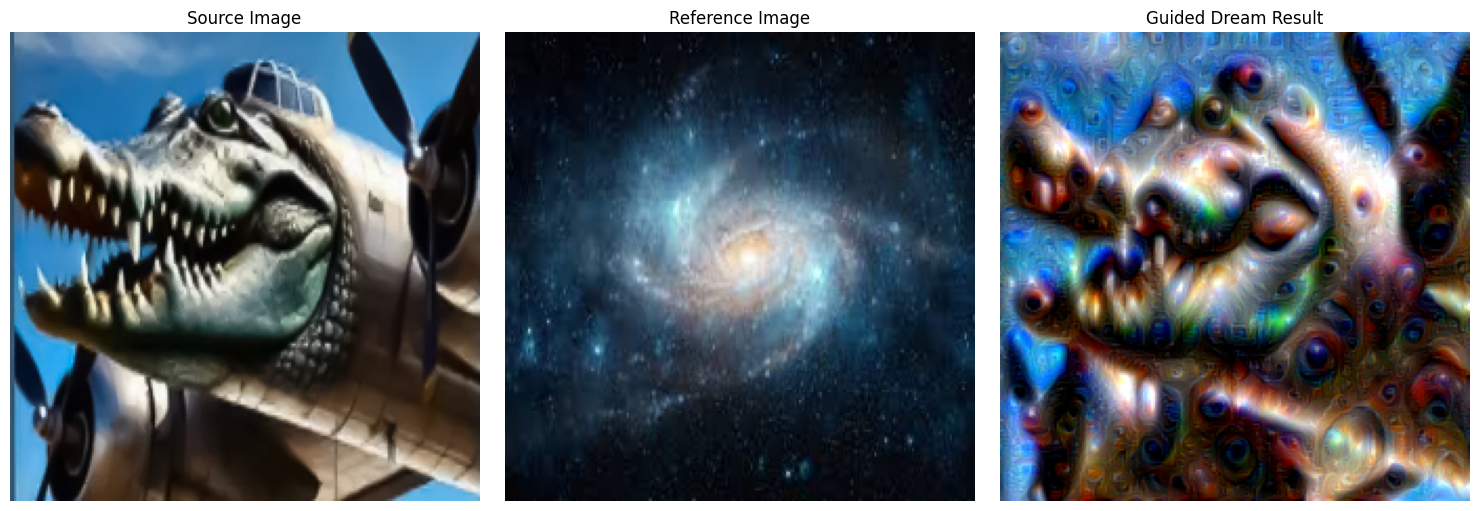

In [17]:
source_name, source_img = images[0]
reference_name, reference_img = images[1]

print(f"Creating a guided dream: {source_name} (source) → {reference_name} (reference)")
result = dreamer.dream_guided(source_img, reference_img, config=config)

show_images_row(
    [source_img, reference_img, result],
    titles=["Source Image", "Reference Image", "Guided Dream Result"],
    figsize=(15, 5),
)

## 6. Generate All Pairwise Guided Dreams

Let's generate all pairwise combinations of guided dreams between our images and store them in a 2D array for efficient access. This approach will help with memory management when we display the grid.

In [18]:
def generate_all_dreams(images, config):
    """
    Generate guided dreams for all pairs of images and store them in a 2D array

    Args:
        images: List of (name, image) tuples
        config: DreamConfig for the dreaming process

    Returns:
        2D array where result[i][j] contains the guided dream from source i to reference j
        (diagonal elements are None, as we skip self-pairs)
    """
    n = len(images)

    # Initialize 2D array to store results
    # For i=source, j=reference: results[i][j] = dream(images[i], images[j])
    guided_dreams: list[list[np.ndarray | None]] = [[None for _ in range(n)] for _ in range(n)]

    # Calculate total number of pairs (excluding self-pairs)
    total_pairs = n * (n - 1)
    print(f"Generating {total_pairs} guided dreams...")

    # Process all pairs
    for i in range(n):
        source_name, source_img = images[i]

        for j in range(n):
            reference_name, reference_img = images[j]

            # Skip self-pairs (diagonal)
            if i == j:
                # Store the original image on the diagonal
                guided_dreams[i][j] = source_img
                continue

            print(f"Processing dream: {source_name} → {reference_name}")
            # Run guided dream
            dreamed = run_guided_dream(source_img, reference_img, config)

            # Store result in our 2D array
            guided_dreams[i][j] = dreamed

    return guided_dreams

In [19]:
# Generate all pairwise guided dreams and store them in a 2D array
guided_dreams = generate_all_dreams(images, config)
print("All guided dreams generated!")

Generating 12 guided dreams...
Processing dream: bombordiro_crocodilo → space
Processing dream: bombordiro_crocodilo → tree
Processing dream: bombordiro_crocodilo → yoda
Processing dream: space → bombordiro_crocodilo
Processing dream: space → tree
Processing dream: space → yoda
Processing dream: tree → bombordiro_crocodilo
Processing dream: tree → space
Processing dream: tree → yoda
Processing dream: yoda → bombordiro_crocodilo
Processing dream: yoda → space
Processing dream: yoda → tree
All guided dreams generated!


## 7. Display Results Grid

Now let's display all the results in a grid format with the source images as the first column and reference images as the first row.

Displaying grid of all guided dreams...


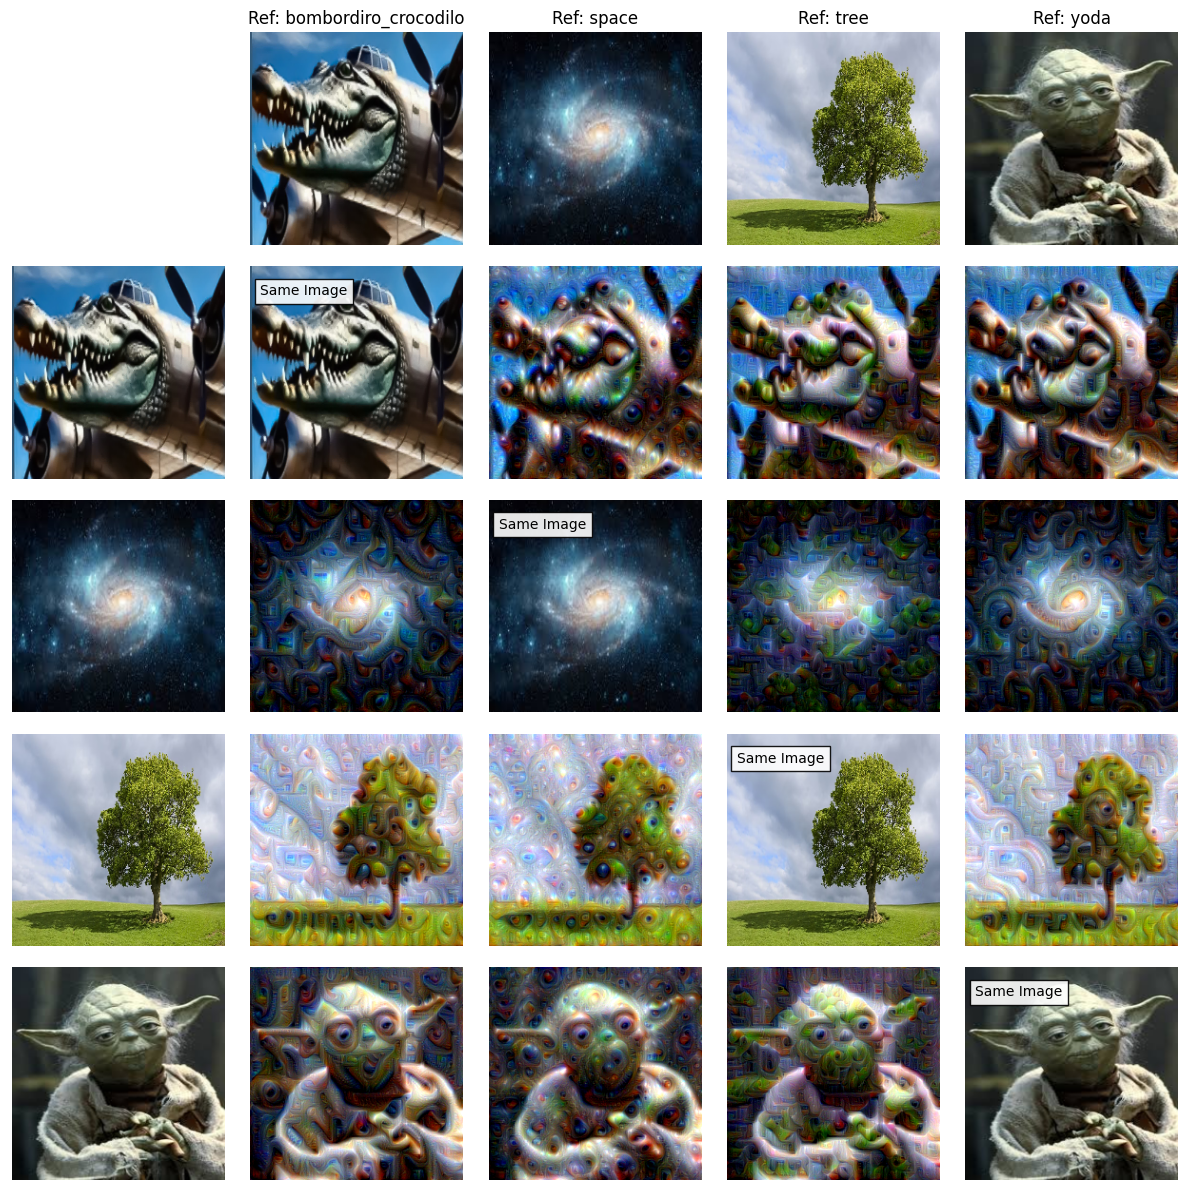

In [20]:
def display_guided_dream_grid(images, guided_dreams):
    """
    Display a grid of guided dreams with source images as rows and reference images as columns

    Args:
        images: List of (name, image) tuples
        guided_dreams: 2D array of guided dream results
    """
    n = len(images)
    image_names = [name for name, _ in images]
    original_images = [img for _, img in images]

    # Create figure with subplots
    # +1 for row/column headers
    fig, axes = plt.subplots(n + 1, n + 1, figsize=(3 * n, 3 * n))

    # Set the top-left corner to blank
    axes[0, 0].axis("off")

    # Set column headers (reference images)
    for j in range(n):
        axes[0, j + 1].imshow(original_images[j])
        axes[0, j + 1].set_title(f"Ref: {image_names[j]}")
        axes[0, j + 1].axis("off")

    # Set row headers (source images)
    for i in range(n):
        axes[i + 1, 0].imshow(original_images[i])
        axes[i + 1, 0].set_ylabel(f"Src: {image_names[i]}", rotation=90, size="large")
        axes[i + 1, 0].axis("off")

    # Fill the grid with guided dream results
    for i in range(n):
        for j in range(n):
            # Get the corresponding guided dream result
            result = guided_dreams[i][j]

            # Display in the grid
            axes[i + 1, j + 1].imshow(result)

            # Mark diagonal (self-pairs) with text
            if i == j:
                axes[i + 1, j + 1].text(10, 30, "Same Image", bbox=dict(facecolor="white", alpha=0.9), fontsize=10)

            # Turn off axis ticks
            axes[i + 1, j + 1].axis("off")

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()


# Display the grid
print("Displaying grid of all guided dreams...")
display_guided_dream_grid(images, guided_dreams)

## 8. Display Individual Examples

Let's also display some individual examples to examine the results more closely.

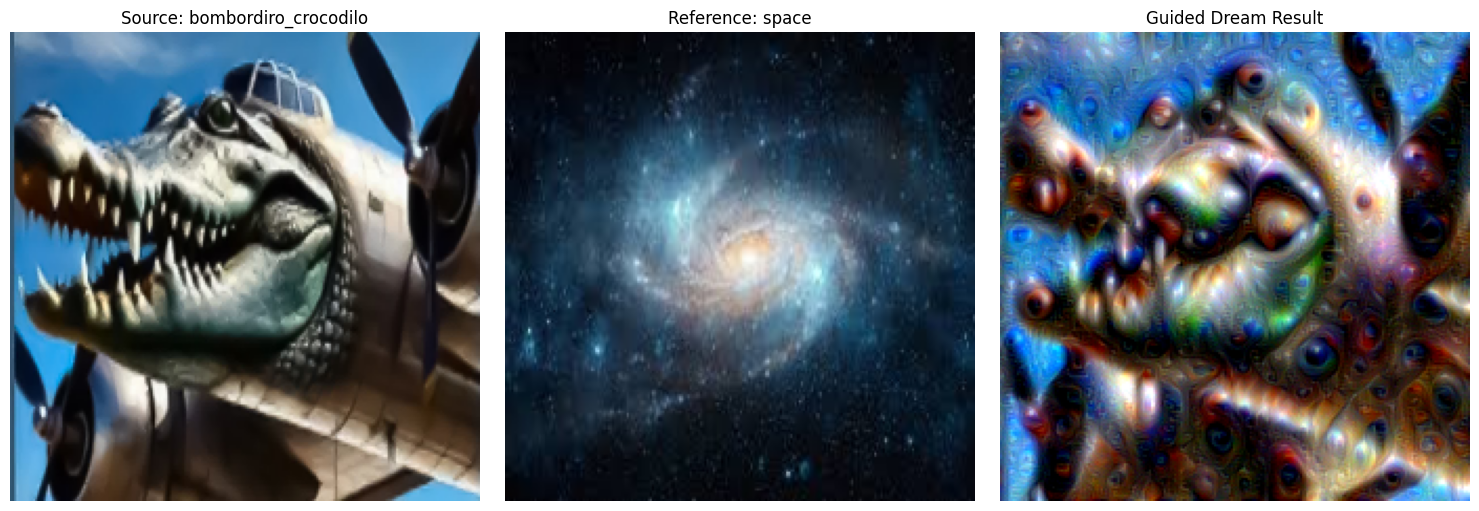

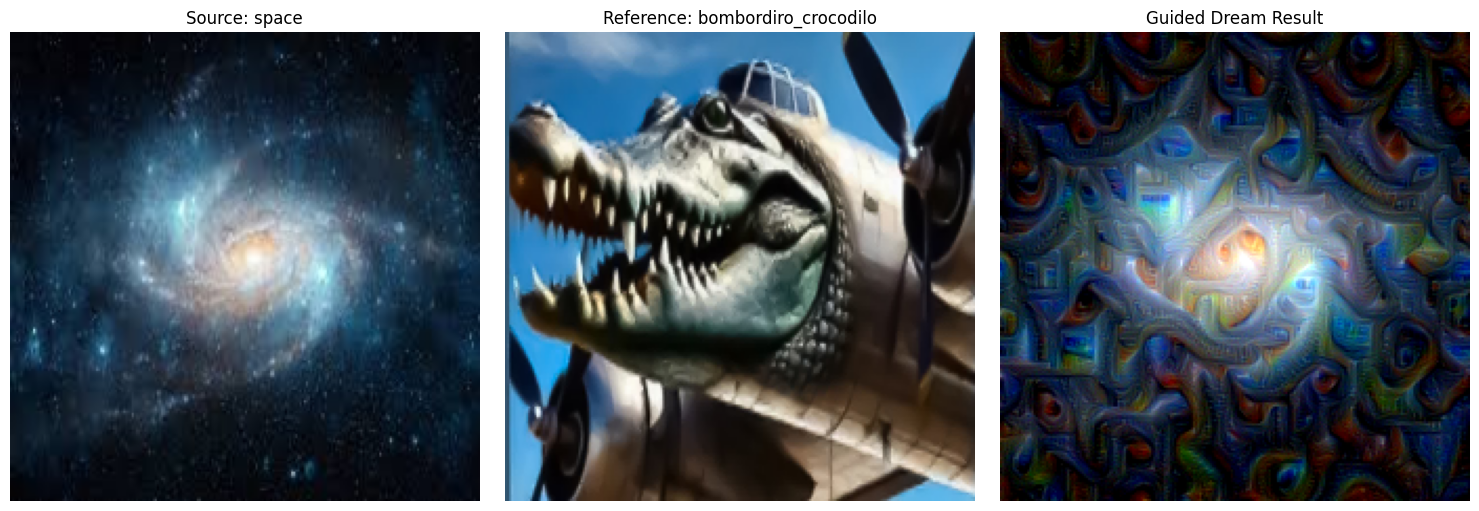

In [21]:
def display_guided_dream_example(i, j, images, guided_dreams):
    """
    Display a single guided dream example with source, reference, and result

    Args:
        i: Index of source image
        j: Index of reference image
        images: List of (name, image) tuples
        guided_dreams: 2D array of guided dream results
    """
    if i == j:
        print("Source and reference are the same. Skipping.")
        return

    source_name, source_img = images[i]
    reference_name, reference_img = images[j]
    result = guided_dreams[i][j]

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(source_img)
    plt.title(f"Source: {source_name}")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(reference_img)
    plt.title(f"Reference: {reference_name}")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(result)
    plt.title("Guided Dream Result")
    plt.axis("off")

    plt.tight_layout()
    plt.show()


# Display a few examples if we have enough images
n = len(images)
if n >= 2:
    # Display the first pair
    display_guided_dream_example(0, 1, images, guided_dreams)

    # Display the reverse direction if available
    if n >= 2:
        display_guided_dream_example(1, 0, images, guided_dreams)

## 9. Save Results (Optional)

Let's save the guided dream results to disk.

In [ ]:
# # Create a directory to save results
# save_dir = "guided_dreams_output"
# os.makedirs(save_dir, exist_ok=True)

# # Save all results
# n = len(images)/
# image_names = [name for name, _ in images]

# for i in range(n):
#     for j in range(n):
#         # Skip self pairs
#         if i == j:
#             continue

#         # Get result
#         result: np.ndarray | None
#         result = guided_dreams[i][j]
#         assert result is not None, "Result is None somehow..."

#         source_name = image_names[i]
#         reference_name = image_names[j]

#         # Create filename
#         filename = f"{save_dir}/{source_name}_guided_by_{reference_name}.jpg"

#         # Convert to appropriate format and save
#         result_uint8 = (result * 255).astype(np.uint8)
#         plt.imsave(filename, result_uint8)

# print(f"All results saved to '{save_dir}' directory")

## 10. Conclusion

In this notebook, we explored DeepDream's guided dreaming capability to transfer features from one image to another. We used the existing DeepDream implementation to create a grid of all pairwise combinations of guided dreams between our set of images.

Key observations:
- Guided dreaming transfers visual elements and textures while maintaining the structure of the source image
- The transfer process creates interesting hybrid images that incorporate patterns from the reference
- The strength of the feature transfer is controlled by the config parameters

Next steps to explore:
- Try different target layers to see how they affect feature transfer
- Adjust the configuration parameters (like pyramid_layers and learning_rate) to control the strength of the effect
- Apply guided dreaming with more specialized images like artistic paintings or abstract patterns
- Experiment with sequential guided dreaming (applying multiple guides in sequence)